In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 08:39:21] [setup] RAM Tracking...
[codecarbon INFO @ 08:39:21] [setup] GPU Tracking...
[codecarbon INFO @ 08:39:21] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 08:39:21] [setup] CPU Tracking...
[codecarbon WARNING @ 08:39:21] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 08:39:24] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 08:39:24] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 08:39:24] >>> Tracker's metadata:
[codecarbon INFO @ 08:39:24]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 08:39:24]   Python version: 3.11.3
[codecarbon INFO @ 08:39:24]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 08:39:24]   Available RAM : 256.000 GB
[codecarbon INFO @ 08:39:24]   CPU count: 24
[codecarbon INFO @ 08:39:24]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [3]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import wandb
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = '/fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb'
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [6]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


ed4k8oqtcr6d


In [7]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [8]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [9]:
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [10]:
full_training_df = pd.read_csv("../../csv/highest_vs_rest_balanced_jira.csv" , index_col = 0)
full_training_df


,text_clean,label,class_original
class,,,
highest,when we do range query on simple keys it does ...,1,Highest
highest,unhandledpromiserejectionwarning unhandled pro...,1,Highest
rest,the fabricunittestdaily branch failing intermi...,0,Medium
rest,as a system operator i want to receive alerts ...,0,Medium
rest,there is no support in datasourcetransactionma...,0,Medium
...,...,...,...
rest,once i have imported a widget into the store i...,0,Low
rest,the spec defines an axiom of a ie singleton li...,0,Medium
rest,to have an history on master of all csvs setup...,0,Medium


In [11]:

# Drop NaN values and reset index of dataframe
full_training_df = full_training_df[full_training_df['text_clean'].notna()]
full_training_df = full_training_df.rename(columns={'text_clean': 'text'})
full_training_df = full_training_df.reset_index()
full_training_df.drop(columns=["class", "class_original"], inplace=True)

In [12]:
full_training_df

,text,label
0,when we do range query on simple keys it does ...,1
1,unhandledpromiserejectionwarning unhandled pro...,1
2,the fabricunittestdaily branch failing intermi...,0
3,as a system operator i want to receive alerts ...,0
4,there is no support in datasourcetransactionma...,0
...,...,...
110711,once i have imported a widget into the store i...,0
110712,the spec defines an axiom of a ie singleton li...,0
110713,to have an history on master of all csvs setup...,0
110714,there are still some changes expected to be me...,1


In [13]:
import pandas as pd
fine_tuning_df = pd.read_csv("../../csv/clean_Jira_balanced.csv")
fine_tuning_df


,text_clean,label
0,using firefox on ubuntu and seeing the same th...,0
1,summary when using bitbucket cloud as a reposi...,0
2,we have identified and fixed a crosssite scrip...,1
3,note this bug is for jira server using jira cl...,0
4,problem definition on the old issue view hover...,0
...,...,...
9327,issue summary when jira and confluence are con...,0
9328,clover database contains fileinfo objects for ...,0
9329,lwjdemacbookpro lwj ping bitbucketorgping bitb...,0
9330,definition all of a sudden some users are unab...,1


In [14]:

fine_tuning_df = fine_tuning_df.rename(columns={'text_clean': 'text'})
fine_tuning_df

,text,label
0,using firefox on ubuntu and seeing the same th...,0
1,summary when using bitbucket cloud as a reposi...,0
2,we have identified and fixed a crosssite scrip...,1
3,note this bug is for jira server using jira cl...,0
4,problem definition on the old issue view hover...,0
...,...,...
9327,issue summary when jira and confluence are con...,0
9328,clover database contains fileinfo objects for ...,0
9329,lwjdemacbookpro lwj ping bitbucketorgping bitb...,0
9330,definition all of a sudden some users are unab...,1


In [15]:
# Split the full training dataframe into training and test dataframes
# 85/15 split. Validation set will be created from the training set later.
train_full_training_df, test_full_training_df = train_test_split(full_training_df)


In [16]:
# Split the fine-tuning data frame into training and test data frames
# Where 30% of the data is used for training and 70% for testing
fine_tune_train_df , fine_tune_test_df = train_test_split(fine_tuning_df, train_percent=.30) # 30%

In [17]:
fine_tune_train_df

,text,label
6405,it was reported as before reported as resolved...,1
6984,error there was an error loading the descripto...,0
2111,project portlets do not respect categories on ...,1
5516,have a bunch of issue that add up to turn on q...,1
6657,issue summary when restoring the index from an...,0
...,...,...
6324,in the review suggestions dialog the table lis...,0
1515,i believe your service incorrectly computed th...,1
216,note this bug report is for jira service desk ...,1
8446,the view email link is generated using the ema...,1


In [18]:
# Concatenate the training dataframes into the final training dataframe
df = pd.concat([train_full_training_df, fine_tune_train_df], ignore_index = True)

In [19]:
df

,text,label
0,currently we are using usrshareelasticsearch a...,0
1,its been over hrs since the mirror has been up...,0
2,there has been discussion on the mailing lists...,0
3,when elytron client tries to obtain clientconf...,1
4,need to be able to release all items at once v...,1
...,...,...
96902,in the review suggestions dialog the table lis...,0
96903,i believe your service incorrectly computed th...,1
96904,note this bug report is for jira service desk ...,1
96905,the view email link is generated using the ema...,1


In [20]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [21]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        16296
       0        16007
1      0        16218
       1        16084
2      0        16197
       1        16105
Name: count, dtype: int64

In [22]:
df

,text,label,kfold
0,currently we are using usrshareelasticsearch a...,0,1
1,its been over hrs since the mirror has been up...,0,2
2,there has been discussion on the mailing lists...,0,2
3,when elytron client tries to obtain clientconf...,1,2
4,need to be able to release all items at once v...,1,2
...,...,...,...
96902,in the review suggestions dialog the table lis...,0,2
96903,i believe your service incorrectly computed th...,1,1
96904,note this bug report is for jira service desk ...,1,2
96905,the view email link is generated using the ema...,1,0


In [23]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [24]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [25]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [26]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [27]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [28]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [30]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [31]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [32]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [33]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [34]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 2019/2019 [04:23<00:00,  7.65it/s, Epoch=1, LR=9.51e-6, Valid_Loss=0.607]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7439    0.5729    0.6473     16007
          HP     0.6577    0.8063    0.7245     16296

    accuracy                         0.6906     32303
   macro avg     0.7008    0.6896    0.6859     32303
weighted avg     0.7004    0.6906    0.6862     32303

Accuracy = 0.6906
F1_score = 0.7245
Validation Loss Improved (inf ---> 0.6074127179179233)
Model Saved



100%|██████████| 2019/2019 [04:24<00:00,  7.65it/s, Epoch=2, LR=8.15e-6, Valid_Loss=0.603]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6245    0.8082    0.7046     16007
          HP     0.7351    0.5227    0.6110     16296

    accuracy                         0.6642     32303
   macro avg     0.6798    0.6655    0.6578     32303
weighted avg     0.6803    0.6642    0.6574     32303

Accuracy = 0.6642
F1_score = 0.611
Validation Loss Improved (0.6074127179179233 ---> 0.6033256452223748)
Model Saved



100%|██████████| 2019/2019 [04:24<00:00,  7.64it/s, Epoch=3, LR=6.2e-6, Valid_Loss=0.594]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6731    0.6516    0.6622     16007
          HP     0.6682    0.6891    0.6785     16296

    accuracy                         0.6705     32303
   macro avg     0.6706    0.6704    0.6703     32303
weighted avg     0.6706    0.6705    0.6704     32303

Accuracy = 0.6705
F1_score = 0.6785
Validation Loss Improved (0.6033256452223748 ---> 0.5937146076354376)
Model Saved

Training complete in 1h 44m 58s
Best Loss: 0.5937


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,█▁▃
Valid F1_score,█▁▅
Valid Loss,█▆▁
Best Loss,0.59371
Train Loss,0.52211
Valid Accuracy,0.6705
Valid F1_score,0.6785
Valid Loss,0.59371



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 2019/2019 [04:26<00:00,  7.56it/s, Epoch=1, LR=9.51e-6, Valid_Loss=0.576]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7051    0.6614    0.6826     16218
          HP     0.6787    0.7210    0.6992     16084

    accuracy                         0.6911     32302
   macro avg     0.6919    0.6912    0.6909     32302
weighted avg     0.6919    0.6911    0.6908     32302

Accuracy = 0.6911
F1_score = 0.6992
Validation Loss Improved (inf ---> 0.5764722020683196)
Model Saved



100%|██████████| 2019/2019 [04:26<00:00,  7.57it/s, Epoch=2, LR=8.15e-6, Valid_Loss=0.566]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6958    0.7177    0.7066     16218
          HP     0.7060    0.6836    0.6946     16084

    accuracy                         0.7007     32302
   macro avg     0.7009    0.7007    0.7006     32302
weighted avg     0.7009    0.7007    0.7006     32302

Accuracy = 0.7007
F1_score = 0.6946
Validation Loss Improved (0.5764722020683196 ---> 0.5660843546453567)
Model Saved



100%|██████████| 2019/2019 [04:26<00:00,  7.57it/s, Epoch=3, LR=6.2e-6, Valid_Loss=0.577]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7341    0.6434    0.6857     16218
          HP     0.6802    0.7650    0.7202     16084

    accuracy                         0.7040     32302
   macro avg     0.7072    0.7042    0.7030     32302
weighted avg     0.7073    0.7040    0.7029     32302

Accuracy = 0.704
F1_score = 0.7202

Training complete in 1h 45m 37s
Best Loss: 0.5661


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁▆█
Valid F1_score,▂▁█
Valid Loss,█▁█
Best Loss,0.56608
Train Loss,0.5129
Valid Accuracy,0.704
Valid F1_score,0.7202
Valid Loss,0.57672



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 2019/2019 [04:28<00:00,  7.52it/s, Epoch=1, LR=9.51e-6, Valid_Loss=0.651]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.8666    0.2638    0.4045     16197
          HP     0.5644    0.9591    0.7106     16105

    accuracy                         0.6105     32302
   macro avg     0.7155    0.6115    0.5575     32302
weighted avg     0.7159    0.6105    0.5571     32302

Accuracy = 0.6105
F1_score = 0.7106
Validation Loss Improved (inf ---> 0.6506219079314234)
Model Saved



100%|██████████| 2019/2019 [04:28<00:00,  7.51it/s, Epoch=2, LR=8.15e-6, Valid_Loss=0.561]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7295    0.6528    0.6890     16197
          HP     0.6842    0.7565    0.7185     16105

    accuracy                         0.7045     32302
   macro avg     0.7068    0.7047    0.7038     32302
weighted avg     0.7069    0.7045    0.7037     32302

Accuracy = 0.7045
F1_score = 0.7185
Validation Loss Improved (0.6506219079314234 ---> 0.5609605721324363)
Model Saved



100%|██████████| 2019/2019 [04:28<00:00,  7.51it/s, Epoch=3, LR=6.2e-6, Valid_Loss=0.569]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6764    0.7709    0.7205     16197
          HP     0.7319    0.6291    0.6766     16105

    accuracy                         0.7002     32302
   macro avg     0.7041    0.7000    0.6986     32302
weighted avg     0.7041    0.7002    0.6986     32302

Accuracy = 0.7002
F1_score = 0.6766

Training complete in 1h 45m 55s
Best Loss: 0.5610


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁██
Valid F1_score,▇█▁
Valid Loss,█▁▂
Best Loss,0.56096
Train Loss,0.51694
Valid Accuracy,0.7002
Valid F1_score,0.6766
Valid Loss,0.56904


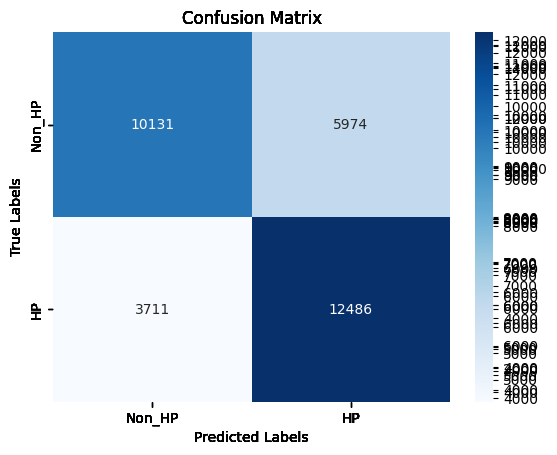

In [35]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [36]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [37]:
test_df = fine_tune_test_df

In [38]:
test_df

,text,label
5273,since two weeks i have sometimes this message ...,1
6591,in wiki the links to issues in issue tracker a...,0
3706,when you select the root branch in the branch ...,0
893,entering more than characters in the applicati...,0
5937,trying to push to git i am getting this error ...,1
...,...,...
5734,note this bug report is for confluence cloud u...,1
5191,the updatingstatus action is vulnerable to sto...,1
5390,hiwhile trying to push my commits to repo i am...,1
860,users with no administrative permissions see a...,0


In [39]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [40]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [41]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [42]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [43]:
# Change the HASH_NAME according to new generated hash for your run
#HASH_NAME = "ekgx4wmexn91"


In [44]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 409/409 [00:54<00:00,  7.45it/s]


Fold 1


100%|██████████| 409/409 [00:54<00:00,  7.45it/s]


Fold 2


100%|██████████| 409/409 [00:54<00:00,  7.45it/s]


In [45]:
deberta_predictions


[array([[0.64316374, 0.35683623],
        [0.75811344, 0.24188657],
        [0.57248193, 0.42751807],
        ...,
        [0.24787337, 0.75212663],
        [0.6051867 , 0.39481327],
        [0.87754214, 0.12245779]], dtype=float32),
 array([[0.58083904, 0.41916096],
        [0.6895582 , 0.31044182],
        [0.71519136, 0.2848087 ],
        ...,
        [0.25442505, 0.7455749 ],
        [0.58018523, 0.41981474],
        [0.8784394 , 0.12156054]], dtype=float32),
 array([[0.43724695, 0.562753  ],
        [0.65511036, 0.34488967],
        [0.64076895, 0.35923105],
        ...,
        [0.23636329, 0.7636367 ],
        [0.5552342 , 0.44476575],
        [0.8155165 , 0.1844835 ]], dtype=float32)]

In [46]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.5537499 , 0.44625005],
       [0.7009273 , 0.2990727 ],
       [0.6428141 , 0.35718593],
       ...,
       [0.24622057, 0.7537794 ],
       [0.58020204, 0.4197979 ],
       [0.857166  , 0.14283393]], dtype=float32)

In [47]:
len(predictions)

6533

In [48]:
predictions

array([[0.5537499 , 0.44625005],
       [0.7009273 , 0.2990727 ],
       [0.6428141 , 0.35718593],
       ...,
       [0.24622057, 0.7537794 ],
       [0.58020204, 0.4197979 ],
       [0.857166  , 0.14283393]], dtype=float32)

In [49]:
test_df["prediction_0"] = predictions[:, 0] 

In [50]:
test_df["prediction_1"] = predictions[:, 1] 

In [51]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [52]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
5273,since two weeks i have sometimes this message ...,1,0.553750,0.446250,0,0,1
6591,in wiki the links to issues in issue tracker a...,0,0.700927,0.299073,0,0,0
3706,when you select the root branch in the branch ...,0,0.642814,0.357186,0,0,0
893,entering more than characters in the applicati...,0,0.722229,0.277771,0,0,0
5937,trying to push to git i am getting this error ...,1,0.287530,0.712470,1,1,1
...,...,...,...,...,...,...,...
5734,note this bug report is for confluence cloud u...,1,0.221697,0.778303,1,1,1
5191,the updatingstatus action is vulnerable to sto...,1,0.406426,0.593574,1,1,1
5390,hiwhile trying to push my commits to repo i am...,1,0.246221,0.753779,1,1,1
860,users with no administrative permissions see a...,0,0.580202,0.419798,0,0,0


In [53]:
len(test_df)

6533

In [54]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [55]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [56]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [57]:
test_df["pred"] = test_df["pred"].astype(int)

In [58]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
5273,since two weeks i have sometimes this message ...,1,0.553750,0.446250,0,0,1,prediction_0,0
6591,in wiki the links to issues in issue tracker a...,0,0.700927,0.299073,0,0,0,prediction_0,0
3706,when you select the root branch in the branch ...,0,0.642814,0.357186,0,0,0,prediction_0,0
893,entering more than characters in the applicati...,0,0.722229,0.277771,0,0,0,prediction_0,0
5937,trying to push to git i am getting this error ...,1,0.287530,0.712470,1,1,1,prediction_1,1
...,...,...,...,...,...,...,...,...,...
5734,note this bug report is for confluence cloud u...,1,0.221697,0.778303,1,1,1,prediction_1,1
5191,the updatingstatus action is vulnerable to sto...,1,0.406426,0.593574,1,1,1,prediction_1,1
5390,hiwhile trying to push my commits to repo i am...,1,0.246221,0.753779,1,1,1,prediction_1,1
860,users with no administrative permissions see a...,0,0.580202,0.419798,0,0,0,prediction_0,0


In [59]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[2094 1174]
 [ 795 2470]]


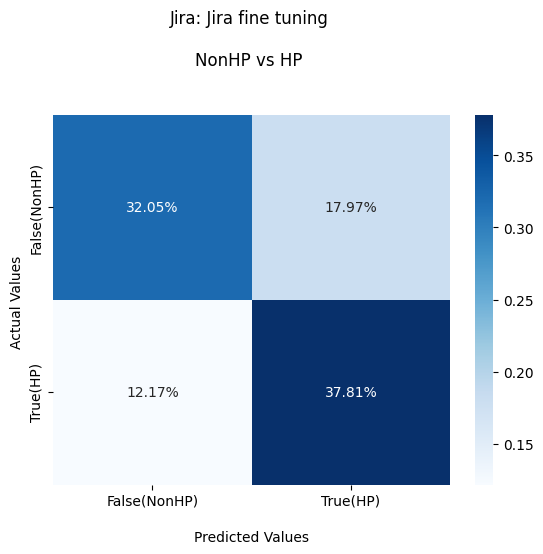

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Jira: Jira fine tuning \n\nNonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [61]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.72      0.64      0.68      3268
           1       0.68      0.76      0.72      3265

    accuracy                           0.70      6533
   macro avg       0.70      0.70      0.70      6533
weighted avg       0.70      0.70      0.70      6533



In [62]:
test_df[["text","label","pred"]].to_csv("Jira_70_Test_inference.csv")

In [63]:
tracker.stop()

0.04990150810389611